# Extreme weather detection

In this notebook, we load data from different sources. We build classifiers based on our labelled data set from https://crisislex.org/data-collections.html#CrisisLexT6 and with the use cases:

1. Alberta floods https://en.wikipedia.org/wiki/2013_Alberta_floods 
2. Queensland floods https://en.wikipedia.org/wiki/Cyclone_Oswald


The classifiers are build in three different categories within machine learning: simple ML algorithms, Deep Learning and Transfer learning. After this follows the design of a localization algorithm for localizing the tweets in order to map them. 



The performance for each classifier is evaluated and then used for labelling tweets from the unlabelled data set which comes from ... and is collected at a global scale in the periode from 2014-2016. We filtered out only the english tweets.

We split the tweets in 10 separate files. 

1. Load data
2. Clean 
3. Classify (label)
4. Localize
5. Visualize



In [1]:

from __future__ import division, print_function

import pandas as pd
import numpy as np
import re
import urllib.request

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
import os
import string  
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image, ImageFont
import math
from fa2 import ForceAtlas2
import community
import datetime as dt
import warnings
from ast import literal_eval
import json

from fastai import *
from fastai.text import *
from pathlib import Path
import re

!pip install geograpy3
import geograpy

import folium
from folium.plugins import MarkerCluster

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.metrics import confusion_matrix

from ast import literal_eval

import warnings
warnings.filterwarnings("ignore")

from urllib.request import urlopen
import requests

import ast 
import random

#from jupyterthemes import jtplot
from seaborn import color_palette
import community
import collections

# VIZ
import plotly.express as px 
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from ipywidgets import widgets

import altair as alt 
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from tqdm import tqdm
import folium
from folium import FeatureGroup, LayerControl, plugins, Map, Marker
from folium.plugins import FastMarkerCluster, MarkerCluster
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from nltk import word_tokenize
from gensim import models
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding, SimpleRNN
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.backend import clear_session
import spacy
#from spacymoji import Emoji


     |████████████████████████████████| 1.5MB 18.8MB/s 
     |████████████████████████████████| 215kB 58.7MB/s 
     |████████████████████████████████| 92kB 14.4MB/s 
     |████████████████████████████████| 10.1MB 54.6MB/s 
     |████████████████████████████████| 81kB 12.8MB/s 
     |████████████████████████████████| 92kB 14.8MB/s 
     |████████████████████████████████| 7.4MB 43.1MB/s 
     |████████████████████████████████| 235kB 59.6MB/s 
     |████████████████████████████████| 51kB 10.3MB/s 
  Created wheel for pycountry: filename=pycountry-20.7.3-py2.py3-none-any.whl size=10746863 sha256=3d5d743120ea437c33abad1248bfc8c5167972519df9d8f5fb04077903bbf12b
  Stored in directory: /root/.cache/pip/wheels/33/4e/a6/be297e6b83567e537bed9df4a93f8590ec01c1acfbcd405348
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-cp37-none-any.whl size=13538 sha256=e57af8cc3c68987e0c7dbcddfa4d0f150f07f38366fd59a40e9b372c8c00dc11
  Stored in directory: /root/.cache/pip/wheels/81/2b/43/a02ede723

# Data extraction


### Flood tweets

Change ids in text file

- remove t-
- in commandline, hydrate files and save by 'twarc hydrate flood_tweets_{i+1}.txt > flood_tweets_{i+1}.jsonl

### CrisisLex

In [ ]:
# get user dataframe

def get_userinfo(df_join1):  
    
    df_join1 = df_join1.rename(columns={'id': 'tweet_id'})
    
    df_join1['user_id'] = [df_join1['user'][i]['id'] for i in range(len(df_join1))]

    users = [df_join1['user'][i] for i in range(len(df_join1))]

    df_users = pd.DataFrame(users)

    cols =['id', 'id_str', 'name', 'screen_name', 'location', 'description', 'url',
            'protected', 'followers_count', 'friends_count',
           'listed_count', 'created_at', 'favourites_count', 'utc_offset',
           'time_zone', 'geo_enabled', 'verified', 'statuses_count', 'lang']

    df_users1 = df_users[cols].drop_duplicates().reset_index(drop=True)
    df_users1 = df_users1.rename(columns={'id':'user_id','location':'user_location'})
    
    df_join2 = pd.merge(df_users1[['user_id','user_location']],df_join1, how='inner', on='user_id').reset_index(drop=True)

    df_join2 = df_join2.replace(r'', np.NaN)
    df_join2 = df_join2.drop_duplicates(subset='tweet_id')
    
    # get only english tweets
    df_join2 = df_join2[df_join2['lang']=='en'].reset_index(drop=True)
   

    return df_join2

In [ ]:
def get_tokens(df_join):
    df_join['tokens'] = ""
    
    for i,content in enumerate(df_join['full_text']):
        if content:
            text = content.translate(str.maketrans('', '', string.punctuation)).split() # split to tokens
            sw = stopwords.words("english") # set stopwords
            wordnet_lemmatizer = WordNetLemmatizer() # set lemmatizer
            words1= [t.lower() for t in text] # lower letters
            words11 = [t for t in words1 if t not in sw]   # remove stopwords
            words2 = [wordnet_lemmatizer.lemmatize(t) for t in words11]  # lemmatize
            words3 = [x for x in words2 if not any(c.isdigit() for c in x)] # remove words with numbers

            df_join['tokens'][i] = words3
            
    return df_join


# Load and clean LABELLED tweets

In [ ]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

First entire data set

In [ ]:

link ="https://drive.google.com/file/d/1pxndUgzMrv7kzVb20uN7qc2-G_nzIySy/view?usp=sharing"

id = link.split('/')[5]
print (id) # Verify that you have everything after '='

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')  
df = pd.read_csv('Filename.csv')

df = df[df['tokens'].notna()].reset_index(drop=True)


#df = pd.read_csv('../Flood_data/labelled/final_labelled_tweets.csv')
df['tokens'] = [literal_eval(s) for s in df['tokens'] if s!=np.nan]


for i in range(len(df)):
    try:
        df['geo'][i] = eval(df['geo'][i])
    except:
        df['geo'][i] = np.nan
    try:
        df['place'][i] = eval(df['place'][i])
    except:
        df['place'][i] = np.nan
        
df.head()

1pxndUgzMrv7kzVb20uN7qc2-G_nzIySy


,created_at,tweet_id,full_text,source,reply_tweet_id,user,geo,coordinates,place,retweet_count,retweeted,retweeted_status,area,relevant,user_id,user_name,user_screen_name,user_location,user_description,user_url,user_followers_count,user_friends_count,user_favourites_count,user_verified,user_statuses_count,tokens,duplicates,original_tweet_id,is_reply,created_at_year,created_at_month,created_at_weekday
0,2013-06-21 03:50:08+00:00,3.479244e+17,Party in Miami tonight! The #Heat have done it...,"<a href=""http://twitter.com/download/iphone"" r...",none,"{'id': 18378139, 'id_str': '18378139', 'name':...","{'type': 'Point', 'coordinates': [51.04213308,...","{'type': 'Point', 'coordinates': [-114.0645910...","{'id': '2468025af2bcc4cb', 'url': 'https://api...",0.0,False,none,Alberta,0,18378139.0,Tony Esteves,ExtremeEnergy,Canada,"Tony is a play-based workshop facilitator, a c...",https://t.co/MbJtJgksLB,1462.0,2407.0,418.0,False,2738.0,"[party, miami, tonight, heat, done, nba, champ...",0.0,NaN,False,2013.0,6.0,4.0
1,2013-06-21 19:29:15+00:00,3.481607e+17,Downtown Calgary is now under a controlled eva...,"<a href=""http://twitter.com/download/iphone"" r...",none,"{'id': 18378139, 'id_str': '18378139', 'name':...","{'type': 'Point', 'coordinates': [51.00950318,...","{'type': 'Point', 'coordinates': [-114.1180716...","{'id': '2468025af2bcc4cb', 'url': 'https://api...",0.0,False,none,Alberta,1,18378139.0,Tony Esteves,ExtremeEnergy,Canada,"Tony is a play-based workshop facilitator, a c...",https://t.co/MbJtJgksLB,1462.0,2407.0,418.0,False,2738.0,"[downtown, calgary, controlled, evacuation, wo...",0.0,NaN,False,2013.0,6.0,4.0
2,2013-06-21 07:18:20+00:00,3.479768e+17,Is it in poor taste to inform my calgary frien...,"<a href=""http://twitter.com/download/iphone"" r...",none,"{'id': 213143054, 'id_str': '213143054', 'name...","{'type': 'Point', 'coordinates': [51.036567, -...","{'type': 'Point', 'coordinates': [-114.0867248...","{'id': '2468025af2bcc4cb', 'url': 'https://api...",0.0,False,none,Alberta,1,213143054.0,James Nguyen,jimmy_9186,calgary,"Father of 2, purveyor of libations, lover of f...",NaN,474.0,240.0,104.0,False,981.0,"[poor, taste, inform, calgary, friend, today, ...",0.0,NaN,False,2013.0,6.0,4.0
3,2013-06-30 05:42:30+00:00,3.512141e+17,@CPBAbarAB @milktigerlounge so when's my first...,"<a href=""http://twitter.com/download/iphone"" r...",3.5109969729488486e+17,"{'id': 213143054, 'id_str': '213143054', 'name...","{'type': 'Point', 'coordinates': [51.03789171,...","{'type': 'Point', 'coordinates': [-114.0867816...","{'id': '2468025af2bcc4cb', 'url': 'https://api...",0.0,False,none,Alberta,0,213143054.0,James Nguyen,jimmy_9186,calgary,"Father of 2, purveyor of libations, lover of f...",NaN,474.0,240.0,104.0,False,981.0,"[cpbabarab, milktigerlounge, first, paycheck]",0.0,NaN,True,2013.0,6.0,6.0
4,2013-06-21 15:17:34+00:00,3.480974e+17,@Crackmacs same seems like 1/2 of#yyc is shut ...,"<a href=""http://twitter.com/download/iphone"" r...",3.4809680555842765e+17,"{'id': 461148492, 'id_str': '461148492', 'name...","{'type': 'Point', 'coordinates': [51.11127652,...","{'type': 'Point', 'coordinates': [-114.0755782...","{'id': '2468025af2bcc4cb', 'url': 'https://api...",0.0,False,none,Alberta,1,461148492.0,Eugene O'Brien,smeddy4200,Calgary Alb,Prep Supervisor FT Follow Me & @PixeyNicole My...,http://t.co/fB5IwqlETq,114.0,32.0,447.0,False,3685.0,"[crackmacs, seems, like, ofyyc, shut, yycflood]",0.0,NaN,True,2013.0,6.0,4.0


In [ ]:
# Then flood training data set
link ="https://drive.google.com/file/d/1uALKWXbpw7oIBzrdy5QomE0iP2EeLkdj/view?usp=sharing"

id = link.split('/')[5]
print (id) # Verify that you have everything after '='

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')  
df_clas = pd.read_csv('Filename.csv')

df_clas = df_clas[df_clas['tokens'].notna()].reset_index(drop=True)

#df = pd.read_csv('../Flood_data/labelled/final_labelled_tweets.csv
df_clas['tokens'] = [literal_eval(s) for s in df_clas['tokens'] if s!=np.nan]

df_clas.head()

1uALKWXbpw7oIBzrdy5QomE0iP2EeLkdj


,tweet_id,full_text,tokens,relevant
0,295320633775104000,@breebella12 haha damn I didn't get one lol .....,"[haha, damn, nt, get, one, lol, , mine, crapl...",0
1,295320647905722368,people's demand by order #PDRK #stopnucleartes...,"[people, demand, order, pdrk, stopnucleartesti...",0
2,295320684899491840,"@Char_Ferguson oh right, that's shit then :(","[charferguson, oh, right, shit]",0
3,295320949924974592,Sick of hearing about beating ManU &amp; Arsen...,"[sick, hearing, beating, manu, amp, arsen, kud...",0
4,295321470358392833,@l_sharples sweet as.. Looking forward to it,"[lsharples, sweet, looking, forward]",0


#  Classification 

*Event Detection*



Relevant: 6441 that is: 58.61 %
Non-relevant: 4549 that is: 41.39 %


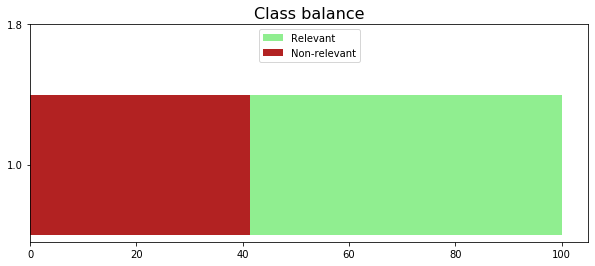

In [ ]:
!pip install matplotlib==3.1.1

X = df_clas['tokens']
y = df_clas['relevant']
plt.figure(figsize=(10,4))

print('Relevant:', sum(y), 'that is:' , round(sum(y)/len(y)*100,2), '%')
print('Non-relevant:', len(y)-sum(y), 'that is:' ,round((len(y)-sum(y))/len(y)*100,2),'%')

p1 = plt.barh(1,100,color='lightgreen')
p2 = plt.barh(1,(len(y)-sum(y))/len(y)*100,color='firebrick')

plt.legend((p1[0], p2[0]), ('Relevant', 'Non-relevant'),loc='upper center')
plt.yticks([1,1.8])
plt.title('Class balance',fontsize=16)
#plt.axis('off')


plt.show()

## Basic NLP algorithms; tf-idf; naive bayes, svm

Variables: tokens, relevant

In [ ]:
def text_fit(X, y, model,clf_model,size):   
    X_c = model.fit_transform(X)
    print('# features: {}'.format(X_c.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=0,test_size=size[0], train_size=size[1])
    print('# train records: {}'.format(X_train.shape[0]))
    print('# test records: {}'.format(X_test.shape[0]))

    clf = clf_model.fit(X_train, y_train)
    pred = clf_model.predict(X_test)

    performance(y_test.tolist(), pred)
   
    return clf,X_c

def performance(y_test,y_pred):

    conf_mat = confusion_matrix(y_test, y_pred)
    
    print('\nConfusion matrix')
    print(conf_mat)
    TN =conf_mat[0][0]
    FP =conf_mat[0][1]
    FN =conf_mat[1][0]
    TP =conf_mat[1][1]

    acc = (TP+TN)/(TP+TN+FP+FN)
    prec = TP/(TP+FP)
    rec = TP/(TP+FN)
    print('Accuracy:',(acc))
    print('Precision: ', prec)
    print('Recall: ', rec)

    return conf_mat



def print_words(model,clf_model,out):
        w = model.get_feature_names()
        coef = clf_model.coef_.tolist()[0]
        coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
        coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
        if out==1:
            print('')
            print('-Top 20 relevant-')
            print(coeff_df.head(20).to_string(index=False))
            print('')
            print('-Top 20 non-relevant-')        
            print(coeff_df.tail(20).to_string(index=False))
        
        return coeff_df
    
    
def predict_relevance(new_tweet,model,clf_model): 
    
    if len(new_tweet)==1:
        rel = clf_model.predict(model.transform([new_tweet]))[0]
    else:
        rel = clf_model.predict(model.transform(new_tweet))
        
        
    return rel

In [ ]:
# https://www.kaggle.com/laowingkin/amazon-fine-food-review-sentiment-analysis

tfidf = TfidfVectorizer(preprocessor=' '.join)
size = [0.1,0.9]

print('Dummy Classifier')
clf_base,X_c_base = text_fit(X, y, tfidf, DummyClassifier(),size)

print(60*'__')


print('\nLogistic Regression')
clf_log,X_c_log = text_fit(X, y, tfidf, LogisticRegression(),size)
print(60*'__')


print('\nSupport Vector Machine')
clf_SVM,X_c_SVM = text_fit(X, y, tfidf,  svm.SVC(),size)

print(60*'__')



Dummy Classifier
# features: 16189
# train records: 9891
# test records: 1099

Confusion matrix
[[171 276]
 [272 380]]
Accuracy: 0.5013648771610555
Precision:  0.5792682926829268
Recall:  0.5828220858895705
________________________________________________________________________________________________________________________

Logistic Regression
# features: 16189
# train records: 9891
# test records: 1099

Confusion matrix
[[426  21]
 [ 38 614]]
Accuracy: 0.9463148316651502
Precision:  0.9669291338582677
Recall:  0.941717791411043
________________________________________________________________________________________________________________________

Support Vector Machine
# features: 16189
# train records: 9891
# test records: 1099

Confusion matrix
[[426  21]
 [ 39 613]]
Accuracy: 0.9454049135577798
Precision:  0.9668769716088328
Recall:  0.9401840490797546
________________________________________________________________________________________________________________________


## Deep learning; word2vec; CNN

### CNN

Source: https://towardsdatascience.com/cnn-sentiment-analysis-1d16b7c5a0e7


Variables: tokens, relevant

In [ ]:
# create new variables for relevant and non-relevant
data = df_clas.rename(columns={'relevant': 'label'}, inplace=False)
pos = []
neg = []
for l in data.label:
    if l == 0:
        pos.append(0)
        neg.append(1)
    elif l == 1:
        pos.append(1)
        neg.append(0)
data['relevant'] = pos
data['not_relevant'] = neg
data.head()

,tweet_id,full_text,tokens,label,relevant,not_relevant
0,295320633775104000,@breebella12 haha damn I didn't get one lol .....,"[haha, damn, nt, get, one, lol, , mine, crapl...",0,0,1
1,295320647905722368,people's demand by order #PDRK #stopnucleartes...,"[people, demand, order, pdrk, stopnucleartesti...",0,0,1
2,295320684899491840,"@Char_Ferguson oh right, that's shit then :(","[charferguson, oh, right, shit]",0,0,1
3,295320949924974592,Sick of hearing about beating ManU &amp; Arsen...,"[sick, hearing, beating, manu, amp, arsen, kud...",0,0,1
4,295321470358392833,@l_sharples sweet as.. Looking forward to it,"[lsharples, sweet, looking, forward]",0,0,1


In [ ]:
# splitting data into test and train
data_train, data_test = train_test_split(data, test_size=0.10, random_state=42)

In [ ]:
# build training vocabulary
all_training_words = [word for tokens in data_train["tokens"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in data_train["tokens"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(TRAINING_VOCAB)))
print("Max sentence length is %s" % max(training_sentence_lengths))

101998 words total, with a vocabulary size of 15401
Max sentence length is 49


In [ ]:
# build testing vocabulary 
all_test_words = [word for tokens in data_test["tokens"] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in data_test["tokens"]]
TEST_VOCAB = sorted(list(set(all_test_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_test_words), len(TEST_VOCAB)))
print("Max sentence length is %s" % max(test_sentence_lengths))

11210 words total, with a vocabulary size of 3746
Max sentence length is 21


In [ ]:
# load google news Word2Vec model 
word2vec_path = 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'
word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [ ]:

def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_comments, generate_missing=False):
    embeddings = clean_comments['tokens'].apply(lambda x: get_average_word2vec(x, vectors, generate_missing=generate_missing))
    return list(embeddings)

In [ ]:
# get embeddings
training_embeddings = get_word2vec_embeddings(word2vec, data_train, generate_missing=True)

# parameters
MAX_SEQUENCE_LENGTH = 40
EMBEDDING_DIM = 300

In [ ]:
# tokenize and pad sequences
tokenizer = Tokenizer(num_words=len(TRAINING_VOCAB), lower=True, char_level=False)
tokenizer.fit_on_texts(data_train['full_text'].tolist())
training_sequences = tokenizer.texts_to_sequences(data_train['full_text'].tolist())



train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

train_cnn_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

Found 21108 unique tokens.


In [ ]:
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))

for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)

print(train_embedding_weights.shape)

(21109, 300)


In [ ]:
test_sequences = tokenizer.texts_to_sequences(data_test["full_text"].tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
# Defining CNN
def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
 
    embedding_layer = Embedding(num_words,
                                embedding_dim,
                                weights=[embeddings],
                                input_length=max_sequence_length,
                                trainable=False)
    
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    
    convs = []
    filter_sizes = [2,3,4,5,6]
    
    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=200, 
                        kernel_size=filter_size, 
                        activation='relu')(embedded_sequences)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)
    
    l_merge = concatenate(convs, axis=1)
    
    x = Dropout(0.1)(l_merge)  
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    
    preds = Dense(labels_index, activation='sigmoid')(x)
    
    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    model.summary()
    return model

In [ ]:
label_names = ['relevant','not_relevant']

x_train = train_cnn_data
y_train = data_train[label_names].values

x_test = test_cnn_data
y_test = data_test[label_names].values

In [ ]:
model = ConvNet(train_embedding_weights, 
                MAX_SEQUENCE_LENGTH, 
                len(train_word_index)+1, 
                EMBEDDING_DIM, 
                len(list(label_names)))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 300)      6332700     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 39, 200)      120200      embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 38, 200)      180200      embedding[0][0]                  
______________________________________________________________________________________________

In [ ]:
# Training CNN
num_epochs = 3
batch_size = 32

clear_session()

hist = model.fit(x_train, 
                 y_train, 
                 epochs=num_epochs, 
                 validation_split=0.1, 
                 shuffle=True, 
                 batch_size=batch_size)

Epoch 1/3
279/279 [==============================] - 37s 13ms/step - loss: 0.3412 - acc: 0.8441 - val_loss: 0.1418 - val_acc: 0.9616
Epoch 2/3
279/279 [==============================] - 2s 7ms/step - loss: 0.1511 - acc: 0.9552 - val_loss: 0.1387 - val_acc: 0.9556
Epoch 3/3
279/279 [==============================] - 2s 7ms/step - loss: 0.1125 - acc: 0.9647 - val_loss: 0.1355 - val_acc: 0.9626


In [ ]:
 test_cnn_data

array([[    0,     0,     0,     0, ...,   511,    35,     4,   374],
       [    0,     0,     0,     0, ...,    34,     1,     2,     3],
       [    0,     0,     0,     0, ...,  2932,    22,     1,   126],
       [    0,     0,     0,     0, ..., 12298,     1,     2,     3],
       ...,
       [    0,     0,     0,     0, ...,    65,     1,     2,     3],
       [    0,     0,     0,     0, ...,   315,   286,   108,   248],
       [    0,     0,     0,     0, ...,  1852,     1,     2,     3],
       [    0,     0,     0,     0, ...,   172,   520,    11,    22]], dtype=int32)

In [ ]:
predictions = model.predict(test_cnn_data, batch_size=1024, verbose=1)
labels = [1, 0]

prediction_labels = []
for p in predictions:
    prediction_labels.append(labels[np.argmax(p)])

sum(data_test.label == prediction_labels)/len(prediction_labels)

2/2 [==============================] - 1s 573ms/step


0.9472247497725205

In [ ]:
data_test.label.value_counts()

1    637
0    462
Name: label, dtype: int64

In [ ]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing accuracy:  {:.4f}".format(accuracy))

Training accuracy: 0.9777
Testing accuracy:  0.9472


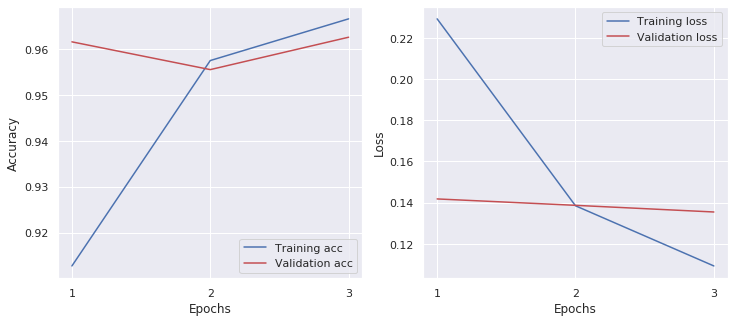

In [ ]:
sns.set()

acc = hist.history['acc']
val_acc = hist.history['val_acc']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
x = range(1, len(acc) + 1)
plt.plot(x, acc, 'b', label='Training acc')
plt.plot(x, val_acc, 'r', label='Validation acc')
plt.xticks(x)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(x, loss, 'b', label='Training loss')
plt.plot(x, val_loss, 'r', label='Validation loss')
plt.xticks(x)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#Confusion Matrix 
_ =performance(data_test.label, prediction_labels)



Confusion matrix
[[440  22]
 [ 36 601]]
Accuracy: 0.9472247497725205
Precision:  0.9646869983948636
Recall:  0.9434850863422292


In [ ]:

# MLP for Pima Indians Dataset Serialize to JSON and HDF5
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
from keras_preprocessing.text import tokenizer_from_json
import numpy
import os

 
# serialize model to JSON
model_json = model.to_json()
with open("CNN.json", "w") as json_file:
    json_file.write(model_json)

tokenizer_json = tokenizer.to_json()
with open('CNN_tokenizer.json','w') as f:
    f.write(tokenizer_json)

# serialize weights to HDF5
model.save_weights("CNN.h5")
print("Saved model to disk")
 
# later...
 


Saved model to disk


In [ ]:
# load json and create model
json_file = open('CNN.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
CNN = model_from_json(loaded_model_json)

json_file = open('CNN_tokenizer.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
CNN_tokenizer = tokenizer_from_json(loaded_model_json)

# load weights into new model
CNN.load_weights("CNN.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
CNN.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])


loss, accuracy = CNN.evaluate(x_train, y_train, verbose=False)
print("Training accuracy: {:.4f}".format(accuracy))

Loaded model from disk


ValueError: ignored

In [ ]:
def predictions_CNN(df,model):
    
    MAX_SEQUENCE_LENGTH = 40
    EMBEDDING_DIM = 300
    
    
    # build training vocabulary
    all_training_words = [word for tokens in df["tokens"] for word in tokens]
    training_sentence_lengths = [len(tokens) for tokens in df["tokens"]]
    TRAINING_VOCAB = sorted(list(set(all_training_words)))
 

    tokenizer = Tokenizer(num_words=len(TRAINING_VOCAB), lower=True, char_level=False)
    tokenizer.fit_on_texts(df['full_text'].tolist())
    sequences = tokenizer.texts_to_sequences(df['full_text'].tolist())
    word_index = tokenizer.word_index

    new_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    predictions = model.predict(new_data, batch_size=1024, verbose=1)
    
    
    labels = [1, 0]

    prediction_labels = []
    for p in predictions:
        prediction_labels.append(labels[np.argmax(p)])
    
    return  prediction_labels

### RNN

##  Transfer learning;  

### ULMFiT



#### Pre-process Tweet data for ULMFiT

Removing non-English characters but nothing else

In [ ]:
def clean_ascii(text):
    # function to remove non-ASCII chars from data
    return ''.join(i for i in text if ord(i) < 128)
df_clas['full_text2'] = df_clas['full_text'].apply(clean_ascii)

In [ ]:
cols2 = ['full_text2','relevant']

df_rel = df_clas[cols2]
print('Rows:',len(df_rel))
display(df_rel.head())

Rows: 10990


,full_text2,relevant
0,@breebella12 haha damn I didn't get one lol .....,0
1,people's demand by order #PDRK #stopnucleartes...,0
2,"@Char_Ferguson oh right, that's shit then :(",0
3,Sick of hearing about beating ManU &amp; Arsen...,0
4,@l_sharples sweet as.. Looking forward to it,0


In [ ]:
size = [0.3,0.7]

X = df_rel['full_text2']
y = df_rel['relevant']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0,test_size=size[0], train_size=size[1])

df_train = pd.DataFrame()
df_test = pd.DataFrame()

df_train['relevant'] = y_train
df_train['text'] = X_train 

df_test['relevant'] = y_test
df_test['text'] = X_test


#### Language model fine-tuning in ULMFiT

In [ ]:
# Language model data
data_lm = TextLMDataBunch.from_df('', train_df=df_train, valid_df=df_test,min_freq=1)
data_lm.show_batch()

# Save the language and classifier model data for re-use
data_lm.save()

idx,text
0,t.co / ls3wkvt6bb xxbos @travkus : xxmaj north xxmaj sask xxmaj river expected to rise 3.5 metres by xxmaj saturday . xxmaj city of xxmaj edmonton under xxmaj flood xxmaj watch . # abflood # yeg xxbos xxmaj our thoughts are with those affected @theage : xxmaj brisbane expected to flood . xxmaj latest from xxmaj queensland http : / / t.co / jzulgiyf via @brisbane times xxbos xxmaj thank
1,rises in xxmaj australia : http : / / t.co / fdavin4y xxrep 16 : # xxup ace xxbos xxmaj helicopters xxmaj deployed to xxmaj rescue xxmaj flood xxmaj victims in xxmaj australia - xxmaj businessweek : http : / / t.co / dip8jqaj.auhelicopters xxmaj depl ... http : / / t.co / iyritjf8 xxbos xxmaj sunset over xxmaj brisbane # breathtaking @ xxmaj mitchelton http : / / t.co
2,"and a ... http : / / t.co / fpbjbftf xxbos xxup rt @yychelps : 5,600 people are signed up on yychelps.ca xxup so xxup proud xxup of xxup you xxup calgary ! # yycflood # yychelps # calgarystrong # xxup amazing xxbos xxmaj well no power for tonight if we are lucky we may get if fix sometime xxmaj tomorrow # xxmaj toowoomba xxbos @markphilippi yeah i saw it"
3,6 . xxbos @girlreporter i see what you did there ... xxbos @cairnzy so sorry i hope anyone in xxmaj australia that was affected by the flood is safe .. xxmaj payers are with u all xxbos xxup rt @shopprsdrugmart : xxmaj donate your xxmaj shoppers xxmaj optimum xxmaj points at any xxup sdm store to the xxmaj canadian xxmaj red xxmaj cross flood relief efforts in xxmaj alberta #
4,"mundine demands respect , complete bullshit truly great athletes xxup gain respect , most have xxup zero respect for him # loosingbattle xxbos xxmaj meeting someone who speaks xxmaj french really gets me going ! xxmaj ooh la la ! xxbos @justinbieber i think i need that xxmaj yellow xxmaj raincoat for the flood # xxmaj australia xxbos xxmaj lets dig deep for our mates up xxmaj north affected by"


In [ ]:
# Language model
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


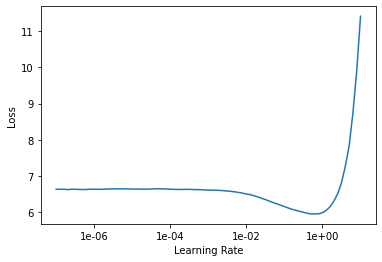

In [ ]:
learn.lr_find(start_lr=1e-8, end_lr=1e2)
learn.recorder.plot()

In [ ]:
#learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)
learn.fit_one_cycle(cyc_len=1, max_lr=1e-2,moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.091143,3.881493,0.351004,00:09


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(cyc_len=20, max_lr=1e-2,moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.847444,3.583099,0.396574,00:12
1,3.565340,3.437439,0.427254,00:12
2,3.279228,3.403733,0.438114,00:12
3,2.943382,3.391718,0.446027,00:13
4,2.749377,3.475320,0.443694,00:13
5,2.415094,3.624585,0.446440,00:13
6,2.104583,3.776063,0.448103,00:14
7,1.825355,3.867135,0.449174,00:14
8,1.558997,4.011671,0.449743,00:13
9,1.308161,4.072132,0.448728,00:13


In [ ]:
learn.predict('Help us. There has been a flooding',n_words=10)

'Help us. There has been a flooding in Alberta , its a bit receding . #'

In [ ]:
# Save the fine-tuned encoder
learn.save_encoder('ft_enc')

In [ ]:
learn.export('Learner.pkl')

#### Classification

In [ ]:
# Classifier model data
data_clas = TextClasDataBunch.from_df('', train_df=df_train, valid_df=df_test, vocab=data_lm.train_ds.vocab, min_freq=1,bs=32)
data_clas.save()

In [ ]:
# Classifier
classifier = text_classifier_learner(data_clas, AWD_LSTM,drop_mult=0.5)
classifier.load_encoder('ft_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (7692 items)
x: TextList
xxbos @astrodamo ah it was a non - event really,xxbos xxmaj holy fuck me in the ass the water just keeps rising http : / / t.co / mib8v5kk,xxbos xxmaj we got kicked out of the backyard cuz one kid gets too excited and is too loud,xxbos xxmaj at stamps game . xxmaj do n't use this bucket . # yycflood fundraiser . http : / / t.co / ls3wkvt6bb,xxbos @travkus : xxmaj north xxmaj sask xxmaj river expected to rise 3.5 metres by xxmaj saturday . xxmaj city of xxmaj edmonton under xxmaj flood xxmaj watch . # abflood # yeg
y: CategoryList
0,1,0,1,1
Path: .;

Valid: LabelList (3297 items)
x: TextList
xxbos xxmaj latest on the xxmaj queensland flood crisis can be found here : http : / / t.co / ykvps8th # sun7 # qldfloods # bigwet,xxbos xxmaj love that xxmaj jay xxmaj feaster gave a shout out to the flood victims of xxmaj southern xxmaj alberta @nhlflames # nhldraft # calgarystrong # calgaryflood,xxbos i think i 'm tired

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


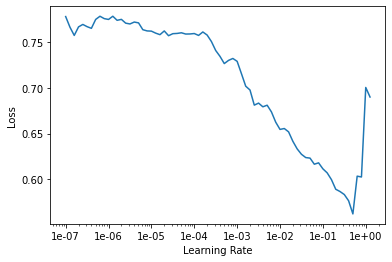

In [ ]:
classifier.lr_find(start_lr=1e-8, end_lr=1e2)
classifier.recorder.plot()

In [ ]:
classifier.fit_one_cycle(cyc_len=1, max_lr=1e-2, moms=(0.8, 0.7))


epoch,train_loss,valid_loss,accuracy,time
0,0.379051,0.267335,0.903245,00:06


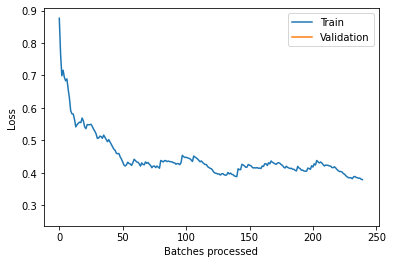

In [ ]:
classifier.recorder.plot_losses()

In [ ]:
classifier.freeze_to(-2)
classifier.fit_one_cycle(1, slice(1e-4,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.294039,0.198646,0.926903,00:07


In [ ]:
classifier.freeze_to(-3)
classifier.fit_one_cycle(1, slice(1e-5,5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.228936,0.182480,0.935396,00:11


In [ ]:
classifier.unfreeze()
classifier.fit_one_cycle(5, slice(1e-5,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.200921,0.214487,0.916288,00:15
1,0.203737,0.195943,0.932363,00:15
2,0.146860,0.192643,0.939945,00:15
3,0.102028,0.188048,0.942372,00:15
4,0.079457,0.193547,0.945405,00:16


In [ ]:
classifier.export('ULMFiT.pkl')


Confusion matrix
Accuracy: 0.9454049135577798
Precision:  0.9639498432601881
Recall:  0.9432515337423313


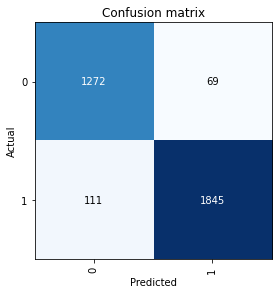

In [ ]:
# get predictions
preds, targets,losses = classifier.get_preds(with_loss=True)
interp =ClassificationInterpretation(classifier,preds, targets, losses)
interp.plot_confusion_matrix()
#predictions = np.argmax(preds, axis=1)
#pd.crosstab(predictions, targets)


print('\nConfusion matrix')
conf_mat = interp.confusion_matrix()
TN =conf_mat[0][0]
FP =conf_mat[0][1]
FN =conf_mat[1][0]
TP =conf_mat[1][1]

acc = (TP+TN)/(TP+TN+FP+FN)
prec = TP/(TP+FP)
rec = TP/(TP+FN)
print('Accuracy:',(acc))
print('Precision: ', prec)
print('Recall: ', rec)

In [ ]:
cl2 = text_classifier_learner()

cl = cl2.load('hello')

TypeError: ignored

In [ ]:
# get predictions
preds, targets,losses = cl.get_preds(with_loss=True)
predictions = np.argmax(preds, axis=1)

_ = performance(targets,predictions)


In [ ]:
!pip install fastbook
from fastbook import *
cl = load_learner('models/ULMFiT.pkl')

     |████████████████████████████████| 727kB 8.4MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 194kB 16.4MB/s 
     |████████████████████████████████| 1.2MB 19.1MB/s 
     |████████████████████████████████| 61kB 9.2MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
     |████████████████████████████████| 12.8MB 236kB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


NameError: ignored

In [ ]:
# Save the language and classifier model data for re-use
data_lm.save()

In [ ]:
df_test['text'][:10].apply(lambda row: str(classifier.predict(row)[0]))

### GPT-2

In [ ]:
# Install transformers library.
!pip install -q git+https://github.com/huggingface/transformers.git
# Install helper functions.
!pip install -q git+https://github.com/gmihaila/ml_things.git

# Localization



In this section, we look into getting a location for the tweets. This by 'geo', then 'place', then 'user_location'. For the tweets with no 'geo', we try to get the location from the tweet text itself based using 

*Note that the “coordinates” attributes is formatted as [LONGITUDE, latitude], while the “geo” attribute is formatted as [latitude, LONGITUDE].

- Coordinates
- Place
- User location
- Geo-parsing



First get only relevant tweets.

In [ ]:
# get relevant tweets

df_rel = df[df['relevant']==1]
print('Relevant tweets:',len(df_rel), '/', len(df))


#subset
#df_rel = df_rel2.sample(200).reset_index(drop=True)

### Geo (coordinate) attribute 


In [ ]:
geo_df = df_rel[~df_rel['geo'].isna()]

#filter only relevant tweets
geo_df = geo_df[geo_df['relevant']==1].reset_index(drop=True)
geo_df['coords'] = [geo_df['geo'][i]['coordinates'] for i in range(len(geo_df))]

print('Geotagged tweets:',len(geo_df), '/', len(df_rel))


In [ ]:
madrid = [40.416775, -3.703790]

locationlist = list(geo_df['coords'])

map2 = folium.Map(location=madrid, tiles='CartoDB dark_matter', zoom_start=2)
marker_cluster = MarkerCluster().add_to(map2)

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=geo_df['full_text'][point]).add_to(marker_cluster)
#map2

### Place attribute


In [ ]:
#users with places
place_df = df_rel[(df_rel['geo'].isna()) & (df_rel['place'].notna())].reset_index(drop=True)

# add place_id
place_df['place_id'] =[place_df['place'][i]['id'] for i in range(len(place_df))]

# get dataframe with places metadata
places = [place_df['place'][i] for i in range(len(place_df))]
df_places= pd.DataFrame(places)

df_places= df_places.rename(columns={'id':'place_id'})
df_places = df_places.drop_duplicates(subset=['place_id'])


# merge to get all place details
place_df2 =pd.merge(place_df.drop(columns=['place']),df_places, on='place_id',how='inner')

cols=['tweet_id','place_type', 'name',
       'full_name', 'country',
       'bounding_box']
# merge to all data

df_rel = pd.merge(df_rel,place_df2[cols],on='tweet_id',how='left').reset_index(drop=True)
df_rel['geo'] = df_rel['geo'].fillna(df_rel['bounding_box'])
df_rel.head(5)

In [ ]:
df_try =  df_rel[~df_rel['geo'].isna()].reset_index(drop=True)

df_try['location_type'] = [g['type'] for g in df_try['geo']]
df_try['coordinates2'] = [g['coordinates'] for g in df_try['geo']]


centers = []

for i in range(len(df_try)):
    if df_try['location_type'][i]=='Polygon':      
        center = list(np.average(df_try['coordinates2'][i][0],axis=0))[::-1]
        centers.append(center)
    else:
        centers.append(df_try['coordinates2'][i])
df_try['centers'] = centers



# merge with df_rel
df_rel = pd.merge(df_rel,df_try[['tweet_id','location_type','centers']],on='tweet_id',how='left').reset_index(drop=True)

In [ ]:
madrid = [40.416775, -3.703790]

locationlist = list(df_try['centers'])

map2 = folium.Map(location=madrid, tiles='CartoDB dark_matter', zoom_start=2)
marker_cluster = MarkerCluster().add_to(map2)

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=df_try['full_text'][point]).add_to(marker_cluster)
#map2

In [ ]:
# map place polygons

polys = list(place_df2['bounding_box'])

for polygon in range(0, len(polys)): 
    folium.GeoJson(polys[polygon]).add_to(marker_cluster)
#map2

### User location

In [ ]:
# initialize geolocator
geolocator = Nominatim(user_agent='my_app') 
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

In [ ]:
df_rel['user_coordinates']= ''


for i,user_loc in enumerate(df_rel['user_location']):  

    if (i % 100) == 0:
      print(i)
    if str(user_loc)!='nan':
        try:
            df_rel['user_coordinates'][i]=[geolocator.geocode(user_loc).latitude,geolocator.geocode(user_loc).longitude]
        except:
            df_rel['user_coordinates'][i] = np.nan
    else:
        df_rel['user_coordinates'][i] = np.nan
  


In [ ]:
df_rel.head()

In [ ]:
from google.colab import files
df_rel.to_csv('filename.csv') 
files.download('filename.csv')

In [ ]:
userloc_df = df_rel[~df_rel['user_location'].isna()]

noloc_df = df_rel[(df_rel['user_location'].isna()) & (df_rel['geo'].isna())  & (df_rel['place'].isna()) ]
noloc_df2 = df_rel[(df_rel['geo'].isna()) & (df_rel['place'].isna()) ]
len(noloc_df2)

In [ ]:
print(f'total : {len(df_rel)}')
print(30*'_' + '\n')

print(f'geotagged : {len(geo_df)}')
print(f'places : {len(place_df2)}')
print(f'user location : {len(userloc_df)}')
print(f'no location : {len(noloc_df)}')

### Geo-parsing

1) toponym recognition

In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

In [ ]:
# get country, region, city and other from geograpy 

df_rel['geoparsing_country'] = ''
df_rel['geoparsing_region'] = ''
df_rel['geoparsing_city'] = ''
df_rel['geoparsing_other'] = ''

for i in range(len(df_rel)):      
    places = geograpy.get_place_context(text = df_rel['full_text'][i])  
    if places.countries !=[]:
        df_rel['geoparsing_country'][i] = places.countries
    if  places.regions !=[]:
        df_rel['geoparsing_region'][i] = places.regions
    if places.cities !=[]:
        df_rel['geoparsing_city'][i] = places.cities
    if places.other !=[]:
        df_rel['geoparsing_other'][i] = places.other

df_rel = df_rel.replace('','NAN')
  

In [ ]:
# prefer city, then region, then country - add to new variable
df_rel['geoparsing_match'] = ''

# if city, then type =1, if region then 2, if country then 3
df_rel['geoparsing_type'] = ''    

for i in range(len(df_rel)):    
    if df_rel['geoparsing_city'][i] != 'NAN':
        df_rel['geoparsing_match'][i] = df_rel['geoparsing_city'][i]
        df_rel['geoparsing_type'][i] = 1
    elif df_rel['geoparsing_region'][i] != 'NAN':
        df_rel['geoparsing_match'][i] = df_rel['geoparsing_region'][i]
        df_rel['geoparsing_type'][i] = 2
    elif df_rel['geoparsing_country'][i] != 'NAN':
        df_rel['geoparsing_match'][i] = df_rel['geoparsing_country'][i]
        df_rel['geoparsing_type'][i] = 3


In [ ]:
df_rel2 = df_rel.replace('NAN',np.nan).replace('',np.nan)
df_rel2 = df_rel2.dropna(subset=['geoparsing_country', 'geoparsing_region','geoparsing_city','geoparsing_other'],how='all').reset_index(drop=True)

# fill nans with geoparsing_other variable
df_rel2.geoparsing_match = df_rel2.geoparsing_match.fillna(df_rel2.geoparsing_other)
df_rel2.geoparsing_type = df_rel2.geoparsing_type.fillna(0)
df_rel2 = df_rel2.dropna(subset=['geoparsing_match'])

# get count of matches
df_rel2['geoparsing_count'] = [len(m) for m in df_rel2['geoparsing_match']]

# drop individual variables
df_rel2=df_rel2.drop(columns=['geoparsing_country', 'geoparsing_region','geoparsing_city','geoparsing_other'])


df_rel2.head()

In [ ]:
# get coordinates from geoparsed locations
locations =  list(df_rel2['geoparsing_match'])
exceptions = [] 

df_rel2['geoparse_coord'] = ''
df_rel2['geoparse_address'] = ''


for i,loc in enumerate(locations): 

    if (i % 100) == 0:
       print(i)

    coords = []
    address = []

    try:
        for loc2 in loc:  
            location = geolocator.geocode(loc2) 
            coords.append([location.latitude,location.longitude])
            address.append(location.address)
        
    except:
        
        exceptions.append(i) 


    df_rel2['geoparse_coord'].iloc[i] = coords
    df_rel2['geoparse_address'].iloc[i] = address
    
# remove those that could not be located    
#df_rel2["geoparse_coord"].replace(df_rel2["geoparse_coord"].str.len() != 0]
df_rel2["geoparse_coord"] = np.where(df_rel2["geoparse_coord"].str.len() == 0, np.nan,df_rel2["geoparse_coord"] )
df_rel2["geoparse_address"] = np.where(df_rel2["geoparse_address"].str.len() == 0, np.nan,df_rel2["geoparse_address"] )

*2) toponym resolution*

1. 'centers' if location_type = Point
2. 'centers' if location_type = Polygon
3. geoparse coords
    - if geoparse coords have two locations, the take one with shortest distance to user coordinates
4. geoparse coords 
5. user coords


First city, then region, then country -- maybe other.

In [ ]:
cols_fin = ['user_id', 'created_at', 'tweet_id', 'full_text',
         'geo', 'tokens',  'location_type', 'centers',
        'user_coordinates', 'user_location',
       'geoparsing_match','geoparsing_type', 'geoparsing_count','geoparse_coord', 'geoparse_address']

df_rel3= df_rel2[cols_fin]
df_rel3.head(3)

In [ ]:
# if geoparse coords have more than 1 location, the take one with shortest distance to user coordinates
# if no user location, then sorry, location cannot be determined 

from scipy.spatial import distance

for j in range(len(df_rel3)):
    
    if df_rel3['geoparsing_count'][j]>1:
        try:
            x = df_rel3['user_coordinates'].iloc[j]
            y = df_rel3['geoparse_coord'].iloc[j]
            idx = np.argmin([distance.euclidean(x,y[i]) for i in range(len(y))])

            df_rel3['geoparse_coord'].iloc[j]=df_rel3['geoparse_coord'].iloc[j][idx]
            df_rel3['geoparse_address'].iloc[j]=df_rel3['geoparse_address'].iloc[j][idx]
        except:             
            df_rel3['geoparse_coord'].iloc[j]='NAN'
            df_rel3['geoparse_address'].iloc[j]='NAN'
                
            
    elif df_rel3['geoparsing_count'][j]==1:
        try:
            df_rel3['geoparse_coord'].iloc[j] =  df_rel3['geoparse_coord'].iloc[j][0]
            df_rel3['geoparse_address'].iloc[j]=df_rel3['geoparse_address'].iloc[j][0]
        except:
            None
            

In [ ]:
#replace np.nan with NAN - only way to make if statement
df_rel3['geoparse_coord'] = df_rel3['geoparse_coord'].replace(np.nan,'NAN')
df_rel3['user_coordinates'] = df_rel3['user_coordinates'].replace(np.nan,'NAN')


# define columns for final coordinates - type
# 1 'centers' if location_type = Point
# 2  'centers' if location_type = Polygon
# 3  geoparse coords
# 4 user coords
# NAN

df_rel3['final_coords'] = ''
df_rel3['final_coords_type'] = ''

for i in range(len(df_rel3)):

        # 'centers' if location_type = Point
    if df_rel3['location_type'][i] == 'Point':
        df_rel3['final_coords'].iloc[i] = df_rel3['centers'].iloc[i]
        df_rel3['final_coords_type'].iloc[i]  = 1

        # 'centers' if location_type = Polygon

    elif df_rel3['location_type'][i] == 'Polygon':
        df_rel3['final_coords'].iloc[i] = df_rel3['centers'].iloc[i]
        df_rel3['final_coords_type'].iloc[i]  = 2

        # geoparse coords 
    elif df_rel3['geoparse_coord'][i] !='NAN':
        df_rel3['final_coords'].iloc[i] = df_rel3['geoparse_coord'].iloc[i]
        df_rel3['final_coords_type'].iloc[i]  = 3

        # user coords
    elif df_rel3['user_coordinates'][i] !='NAN':
        df_rel3['final_coords'].iloc[i] = df_rel3['user_coordinates'].iloc[i]
        df_rel3['final_coords_type'].iloc[i]  = 4
        
         # nan
    else:
        df_rel3['final_coords'].iloc[i] = 'NAN'
        df_rel3['final_coords_type'].iloc[i]  = 'NAN'
    


In [ ]:
# get final dataframe with coordinates

df_final2 = pd.merge(df_rel2,df_rel3[['tweet_id', 'final_coords','final_coords_type']],on='tweet_id',how='left')
df_final3 = df_final2[df_final2['final_coords']!='NAN'].reset_index(drop=True)
df_final2.head()

In [ ]:
# plot

madrid = [40.416775, -3.703790]

locationlist = list(df_final3['final_coords'])
typelist =  list(df_final3['final_coords_type'])

map2 = folium.Map(location=madrid, tiles='CartoDB dark_matter', zoom_start=2)
marker_cluster = MarkerCluster().add_to(map2)

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point],icon=folium.Icon(color='green')).add_to(marker_cluster)

map2

 for point in range(0, len(locationlist)):
     if typelist[point] == 1:
         folium.Marker(locationlist[point], popup=df_final3['final_coords_type'][point],icon=folium.Icon(color='green')).add_to(marker_cluster)
     elif typelist[point] == 2:
         folium.Marker(locationlist[point], popup=df_final3['final_coords_type'][point],icon=folium.Icon(color='yellow')).add_to(marker_cluster)
     elif typelist[point] == 3:
         folium.Marker(locationlist[point], popup=df_final3['final_coords_type'][point],icon=folium.Icon(color='orange')).add_to(marker_cluster)
     elif typelist[point] == 4:
         folium.Marker(locationlist[point], popup=df_final3['final_coords_type'][point],icon=folium.Icon(color='red')).add_to(marker_cluster)


In [ ]:
from google.colab import files
df_final3.to_csv('filename2.csv',index=False) 
files.download('filename2.csv')

# Test Classifier

In this section we load the English unlabelled tweets 

## Load and clean UNLABELLED tweets

In [ ]:

link ="https://drive.google.com/file/d/171KMmzsm_LOWbfd0uj7DTwU6i19EMiKV/view?usp=sharing"

id = link.split('/')[5]
print (id) # Verify that you have everything after '='

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')  

df1= pd.read_json('Filename.json', lines=True)

df2 = get_userinfo(df1)
df_new = get_tokens(df2)

171KMmzsm_LOWbfd0uj7DTwU6i19EMiKV


NameError: ignored

In [ ]:



df1 = pd.read_json('../Flood_data/eng_tweets.json', lines=True,chunksize=10000)

#read to dataframe

dff = pd.DataFrame()
chunks = 5

i = 0
for file in df1:
    i+=1
    print(i)
    if i<chunks:
        dff = pd.concat([dff,file])
    else:
        break

In [ ]:
dff2 = get_userinfo(dff)
dff2.head()

In [ ]:
dff2 = get_tokens(dff2)

In [ ]:
dff2.head()

## Classify tweets

Support Vector Machine

CNN




In [ ]:
# load json and create model
json_file = open('CNN.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
CNN = model_from_json(loaded_model_json)

# load weights into new model
CNN.load_weights("CNN.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
CNN.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])


loss, accuracy = CNN.evaluate(x_train, y_train, verbose=False)
print("Training accuracy: {:.4f}".format(accuracy))


Loaded model from disk
Training accuracy: 0.9777


ULMFiT

## Get location

## Visualize

dff2

In [ ]:
# lowercase, tokens, stem/lemmatize, stopwords - ONLY ENGLISH

df_join['Tokens'] = ""
for i,content in enumerate(df['full_text']):
    if content:
        text = content.translate(str.maketrans('', '', string.punctuation)).split() # split to tokens
        sw = stopwords.words("english") # set stopwords
        wordnet_lemmatizer = WordNetLemmatizer() # set lemmatizer
        words1= [t.lower() for t in text] # lower letters
        words11 = [t for t in words1 if t not in sw]   # remove stopwords
        words2 = [wordnet_lemmatizer.lemmatize(t) for t in words11]  # lemmatize
        words3 = [x for x in words2 if not any(c.isdigit() for c in x)] # remove words with numbers

        df_join['Tokens'][i] = words3
        


In [ ]:
df_join['Tokens']